# New York City Landcover Analysis

### Introduction

New York City, also known as the concrete jungle, isn't well know for having much green in the city aside from central park. Using landsat imagery we can analyze the surface of NYC and determine how much of the city is concrete, and how much is greenery. 

To do this I'll use Normalized Difference Vegetation index (NDVI) to categorize the surfaces level colors into values.

<img src="ndvi.png" alt="Drawing" style="width: 500px;"/>

### Imports

In [2]:
pip install arcgis

  Using cached arcgis-2.1.0.3-cp39-cp39-win_amd64.whl
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip uninstall snappy python-snappy

^C
Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install -U "fsspec[http]>=2021.05.0"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML
import matplotlib.pyplot as plt
import arcgis
import sys
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geometry import lengths, areas_and_lengths, project
from arcgis.geometry import Point, Polyline, Polygon, Geometry
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer
gis = GIS()
#nyc = gis.map('Dublin')
#nyc

In [3]:
landsat_item = gis.content.search('title:Multispectral Landsat', 'Imagery Layer', outside_org=True)[0]
landsat = landsat_item.layers[0]
landsat_item

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>

### Dublin spatial data from ny.gov


In [4]:
area = geocode("Dublin", out_sr=landsat.properties.spatialReference)[0]
landsat.extent = area['extent']

### Landsat image of Dublin

In [5]:
selected = landsat.filter_by(where="(Category = 1) AND (cloudcover <=0.05)",
                            time=[datetime(2020, 4, 1), datetime(2020, 6, 30)],
                             geometry=arcgis.geometry.filters.intersects(area['extent']))

df = selected.query(out_fields="AcquisitionDate, GroupName, CloudCover, DayOfYear",
                    order_by_fields="AcquisitionDate").sdf
df['AcquisitionDate'] = pd.to_datetime(df['AcquisitionDate'], unit='ms')
df

,OBJECTID,AcquisitionDate,GroupName,CloudCover,DayOfYear,SHAPE
0,2978518,2020-05-29 11:16:11,LC08_L1TP_205023_20200529_20200820_02_T1_MTL,0.0184,23,"{""rings"": [[[-369077.6794999987, 7111461.2597]..."


In [6]:
nyc_image = landsat.filter_by('OBJECTID=2978518')

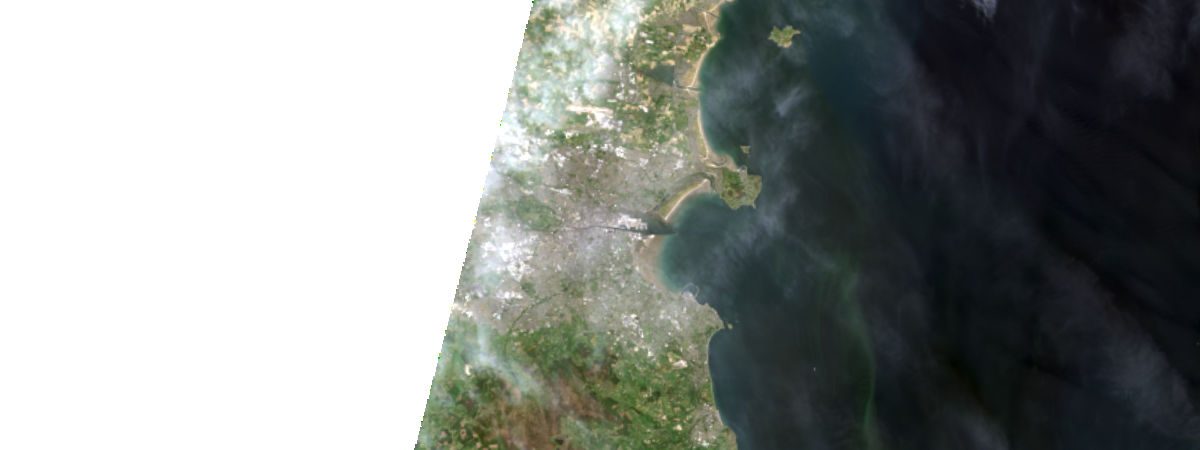

In [7]:
apply(nyc_image, 'Natural Color with DRA')

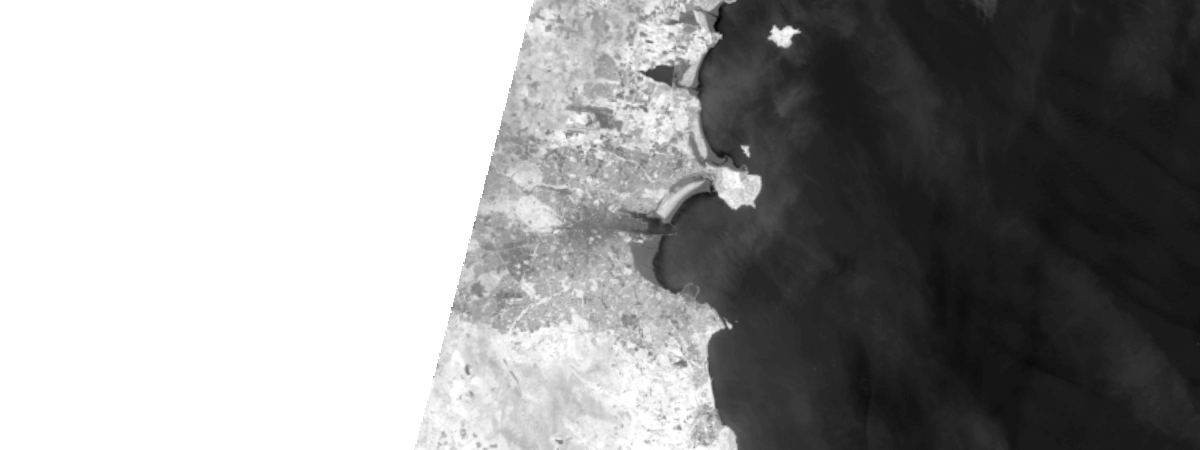

In [8]:
nyc_colorized = apply(nyc_image, 'NDVI Raw')
nyc_colorized

### Dublin clip of just city boundaries

In [9]:
nyc_clip1=nyc_colorized

### NDVI color mask

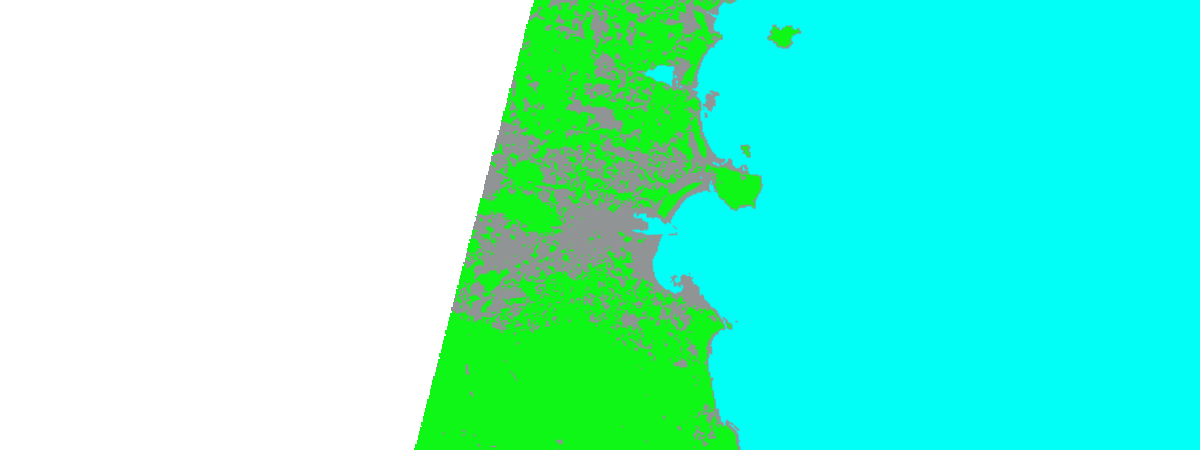

In [10]:
masked = colormap(remap(nyc_clip1, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 144, 148, 148], [3,14,247,22]], astype='u8')

Image(masked.export_image(bbox=area['extent'], size=[1200,450], f='image'))

In [20]:
masked.height

245130

### Landcover Analysis

In [21]:
xpixel = (nyc_clip1.extent['xmax'] - nyc_clip1.extent['xmin']) / 800
ypixel = (nyc_clip1.extent['ymax'] - nyc_clip1.extent['ymin']) / 400

full_res = masked.compute_histograms(nyc_clip1.extent,
                                   pixel_size={'x':xpixel, 'y': ypixel})
total_pix = 0
hist = full_res['histograms'][0]['counts'][0:]
for x in hist[1:]:
    total_pix += x
hist

Exception: Invalid or missing input parameters.
The requested image exceeds the size limit.
(Error Code: 400)

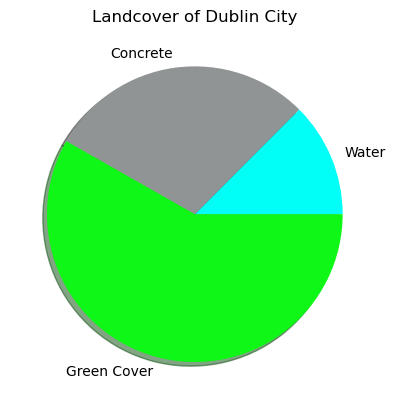

In [14]:
colors=['#0EF716','#01FFF8','#909494']
labels =[ (hist[1]/sum(hist)), (hist[2]/sum(hist)), (hist[3]/sum(hist)) ]
plt.pie(hist, labels=['', 'Water', 'Concrete', 'Green Cover'],colors=colors,
        shadow=True)
plt.title('Landcover of Dublin City')
plt.show()

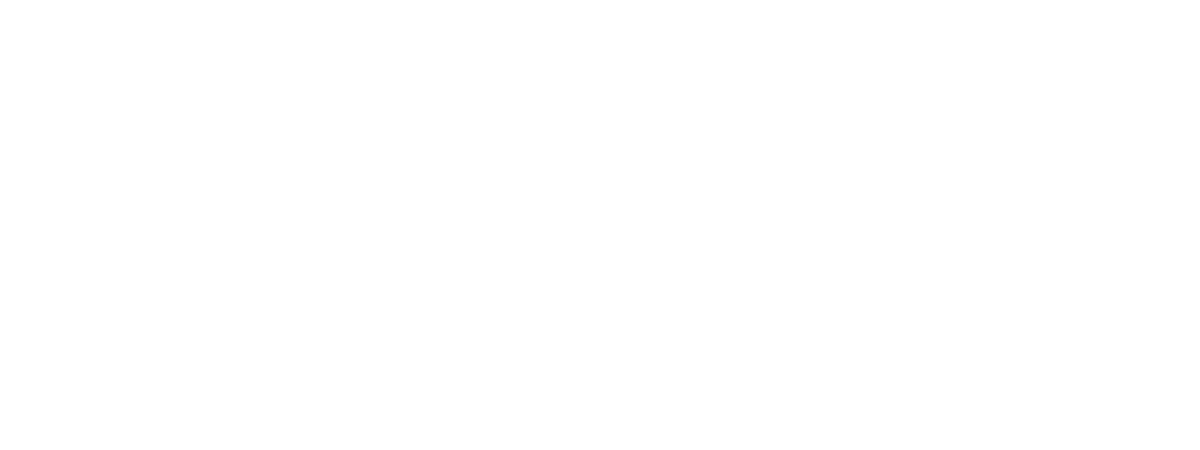

In [66]:
#map varient1
masked_water = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 1, 255, 248], [2, 255, 255, 255], [3,255,255,255]], astype='u8')

Image(masked_water.export_image(bbox=area['extent'], size=[1200,450], f='image'))

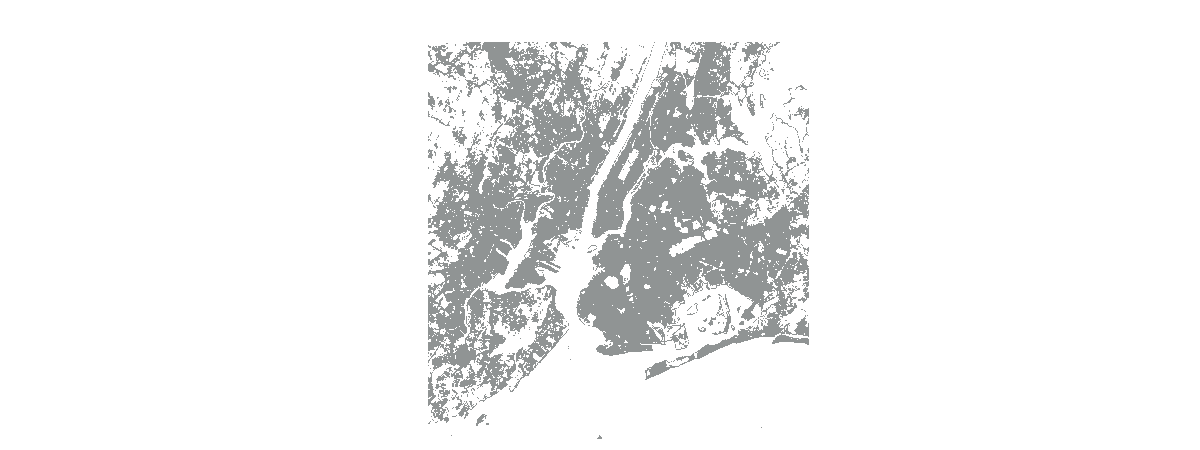

In [40]:
#map varient2
masked_concrete = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2, 144, 148, 148], [3,255,255,255]], astype='u8')

Image(masked_concrete.export_image(bbox=area['extent'], size=[1200,450], f='image'))

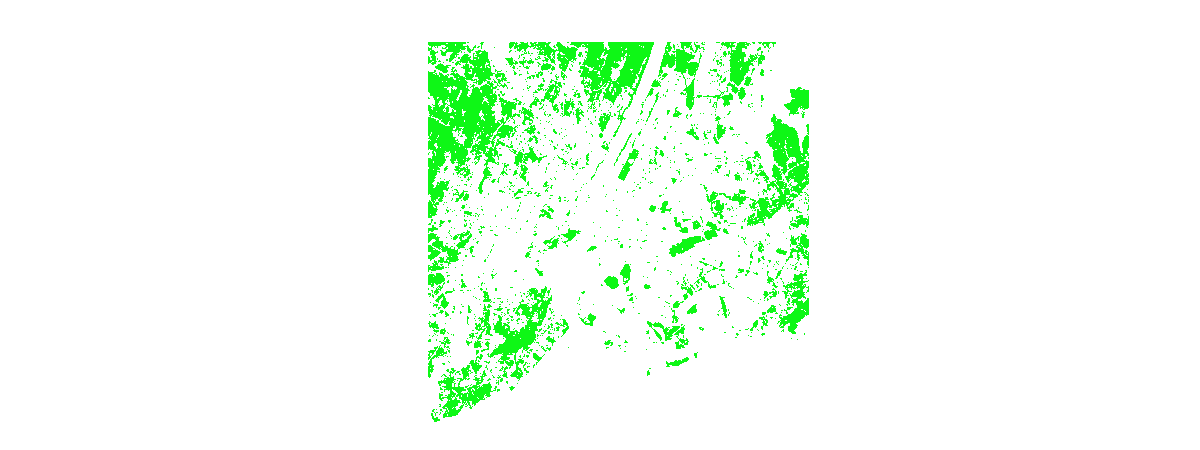

In [41]:
#map varient3
masked_green = colormap(remap(nyc_clip, 
                        input_ranges=[-1,0,     # water
                                     -0.1, 0.4, # Concrete
                                     0.4, 1],   # Vegetation, Trees      
                        output_values=[1, 2, 3]),
                        colormap=[[1, 255, 255, 255], [2, 255, 255, 255], [3,14,247,22]], astype='u8')

Image(masked_green.export_image(bbox=area['extent'], size=[1200,450], f='image'))

In [ ]:
# Import system modules
import arcpy
from arcpy.ia import *

# Set the local variables
raster = "C:/arcpyExamples/data/land_cover.tif"
# pixels with value = 1 will be red, pixels with value = 2 will be green, pixels
# with value = 3 will be blue 
customized_colormap = {"values": [1, 2, 3], "colors": ['red','green','blue']}
#or customized_colormap = [[1, 255, 0, 0], [2, 0, 255, 0], [3, 0, 0, 255]]
# it is same with the one above

# Execute Colormap function
out_land_cover_with_colormap = Colormap(raster, colormap = customized_colormap)

# Display in notebook
out_land_cover_with_colormap